## Predicting Web Traficc - Time Series

Traffic forecast for an ecommerce website with model machine learning XGBoost

In [64]:
# Imports
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [38]:
import seaborn as sns

In [2]:
# Dataset
df = pd.read_csv('dataset\dataset_webtraffic.csv')


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_14876\4293588047.py:2: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('dataset\dataset_webtraffic.csv')


In [3]:
df.head()

,dia_semana,eh_feriado,campanha_marketing_ativa,taxa_media_conversao,num_visitas_dia_anterior,num_visitas
0,4,1,1,14.594054,89,104
1,6,0,1,46.623849,94,128
2,6,0,1,37.389981,96,133
3,6,0,1,27.957446,101,112
4,6,1,0,11.980802,105,120


#### Analise Exploratória:

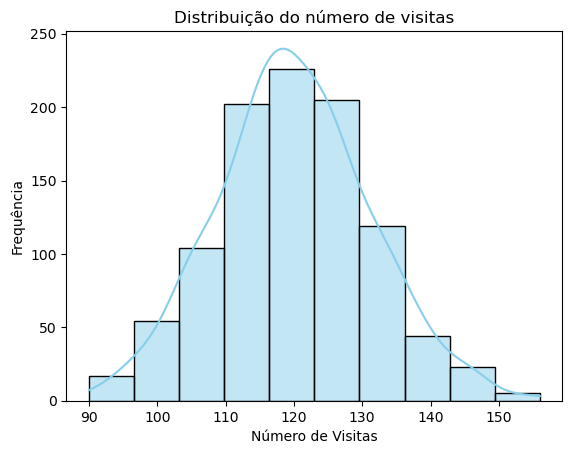

In [41]:
# Distribuicao do numero de visitas
sns.histplot(df['num_visitas'], bins=10, kde=True, color='skyblue')
plt.title('Distribuição do número de visitas')
plt.xlabel('Número de Visitas')
plt.ylabel('Frequência')
plt.show()

**Distribuicao do numero de visitas**

Descrição: Histograma levemente simétrico, indicando que o número de visitas diárias segue aproximadamente uma distribuição normal, centrada entre 115 e 125 visitas.

Insight: Não há evidência forte de assimetria ou de outliers extremos. A maioria dos valores está concentrada em torno da média, o que sugere estabilidade no volume diário de visitas.

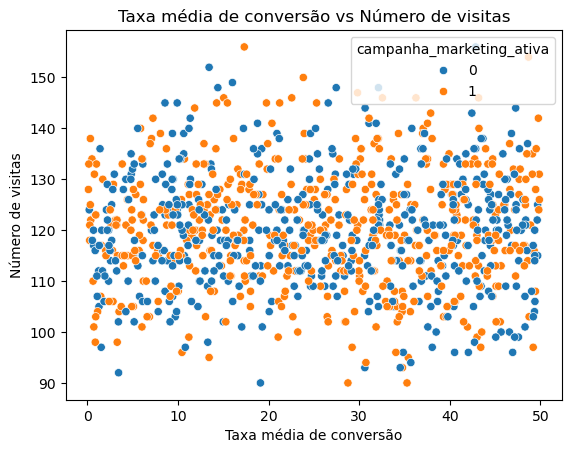

In [ ]:
# Relação entre taxa média de conversão e visitas
sns.scatterplot(x='taxa_media_conversao', y='num_visitas', data=df, hue='campanha_marketing_ativa')
plt.title('Taxa média de conversão vs Número de visitas')
plt.xlabel('Taxa média de conversão')
plt.ylabel('Número de visitas')
plt.show()


**Relação entre taxa média de conversão e visitas**

Descrição: Um scatter plot colorido por campanha_marketing_ativa.

Insight: Não há uma tendência clara entre a taxa média de conversão e o número de visitas. Os pontos estão bem dispersos, indicando pouca correlação direta. Também não se observa diferença visível nas cores (campanhas ativas ou não) impactando drasticamente o padrão.


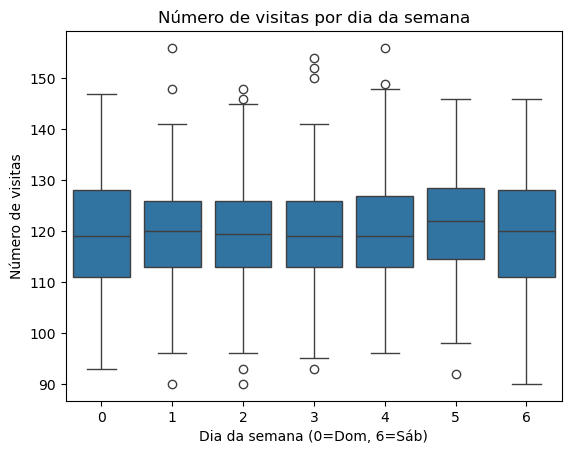

In [43]:
# Efeito do dia da semana
sns.boxplot(x='dia_semana', y='num_visitas', data=df)
plt.title('Número de visitas por dia da semana')
plt.xlabel('Dia da semana (0=Dom, 6=Sáb)')
plt.ylabel('Número de visitas')
plt.show()

**Efeito do dia da semana**

Descrição: Boxplots mostrando distribuição das visitas em cada dia (0=Domingo, 6=Sábado).

Insight: Não parece haver grandes variações entre os dias da semana. As medianas são próximas, indicando que o tráfego é relativamente constante ao longo da semana. Há alguns outliers em todos os dias.

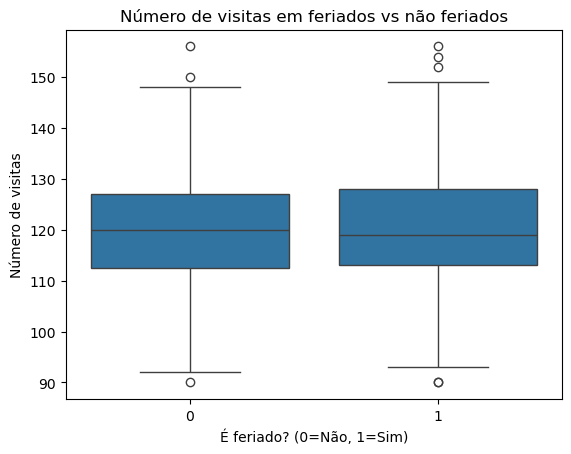

In [44]:
# Visitas em feriados vs não feriados
sns.boxplot(x='eh_feriado', y='num_visitas', data=df)
plt.title('Número de visitas em feriados vs não feriados')
plt.xlabel('É feriado? (0=Não, 1=Sim)')
plt.ylabel('Número de visitas')
plt.show()

**Visitas em feriados vs não feriados**

Descrição: Boxplots comparando visitas em feriados (1) e não feriados (0).

Insight: As distribuições são muito semelhantes, o que indica que feriados não têm um impacto visível no número de visitas. As medianas são praticamente iguais, com amplitude semelhante.

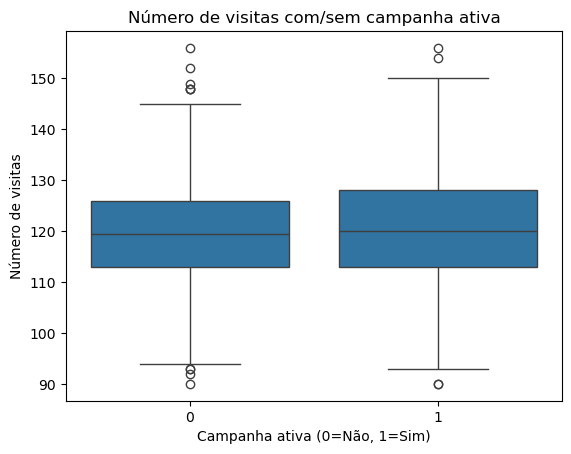

In [45]:
#Efeito da campanha de marketing ativa
sns.boxplot(x='campanha_marketing_ativa', y='num_visitas', data=df)
plt.title('Número de visitas com/sem campanha ativa')
plt.xlabel('Campanha ativa (0=Não, 1=Sim)')
plt.ylabel('Número de visitas')
plt.show()

**Efeito da campanha de marketing ativa**

Descrição: Boxplots para dias com e sem campanhas ativas.

Insight: As distribuições são também muito parecidas. Isso sugere que a variável campanha_marketing_ativa por si só não está relacionada diretamente a um aumento claro no volume de visitas.


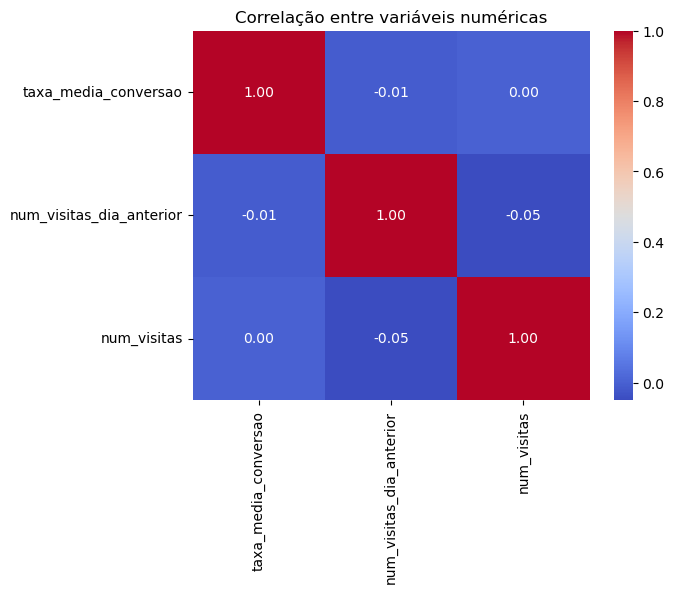

In [46]:
# Correlação entre variáveis numéricas
corr = df[['taxa_media_conversao','num_visitas_dia_anterior','num_visitas']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre variáveis numéricas')
plt.show()

**Correlação entre variáveis numéricas:**

**Descrição**: Um heatmap das correlações entre taxa_media_conversao, num_visitas_dia_anterior e num_visitas.

**Insight**: As correlações são muito fracas (praticamente zero), sugerindo que dentro do intervalo analisado, nenhuma dessas variáveis explica diretamente o comportamento das outras.

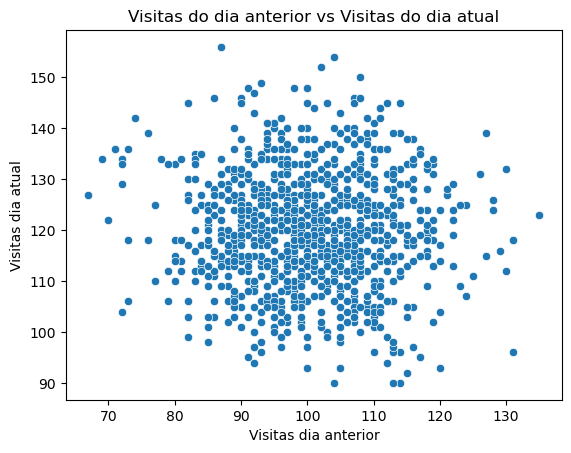

In [47]:
# Relação entre visitas do dia anterior e o dia atual
sns.scatterplot(x='num_visitas_dia_anterior', y='num_visitas', data=df)
plt.title('Visitas do dia anterior vs Visitas do dia atual')
plt.xlabel('Visitas dia anterior')
plt.ylabel('Visitas dia atual')
plt.show()

**Relação entre visitas do dia anterior e o dia atual**

Descrição: Um scatter plot entre visitas do dia anterior e visitas do dia atual.

Insight: Não existe um padrão claro nem uma correlação linear entre o tráfego de um dia e o dia seguinte. O número de visitas varia independentemente do valor do dia anterior.

**Conclusão geral**

A análise exploratória mostra um volume de visitas relativamente estável, sem grandes variações por dia da semana, feriados ou campanhas.

Não há indícios de autocorrelação (visitas de um dia não predizem claramente o próximo) nem correlações fortes com taxa de conversão.

Isso indica que o tráfego pode depender de outros fatores não capturados no dataset, ou requer uma modelagem mais complexa (ex: variáveis sazonais, externas, ou dados históricos mais longos).

Porém para modelagem preditiva, indica fortemente uma série estacionária.

#### Teste de Estacionariedade e Estatísticas Móveis

In [56]:
# Função para testar a estacionaridade (Dickey Fullher)
def testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

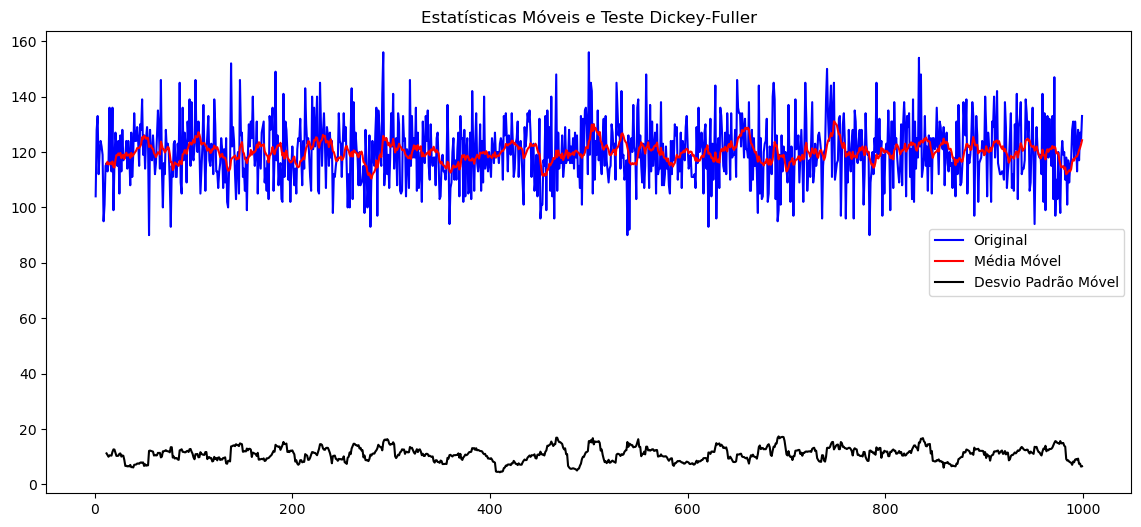


Resultado do Teste Dickey-Fuller:
Estatística do Teste            -21.911253
Valor-p                           0.000000
Número de Lags Consideradas       1.000000
Número de Observações Usadas    997.000000
Valor Crítico (1%)               -3.436926
Valor Crítico (5%)               -2.864443
Valor Crítico (10%)              -2.568316
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [53]:
testa_estacionaridade(df['lag_num_visitas'])

#### Engenharia de Atributos:

In [ ]:
# Cria a lag de 'num_visitas' (defasagem)
df['lag_num_visitas'] = df['num_visitas'].shift(1)

In [5]:
# Remove as primeiras linhas que contêm NaN devido à lag
df = df.dropna()

In [6]:
df.head()

,dia_semana,eh_feriado,campanha_marketing_ativa,taxa_media_conversao,num_visitas_dia_anterior,num_visitas,lag_num_visitas
1,6,0,1,46.623849,94,128,104.0
2,6,0,1,37.389981,96,133,128.0
3,6,0,1,27.957446,101,112,133.0
4,6,1,0,11.980802,105,120,112.0
5,6,0,0,35.641700,128,124,120.0


In [7]:
# Atualiza a lista de features para incluir a lag de 'num_visitas'
features = ['dia_semana', 'eh_feriado', 'campanha_marketing_ativa', 'taxa_media_conversao', 'num_visitas_dia_anterior', 'lag_num_visitas']

In [8]:
target = ['num_visitas']

#### Pre-processamento:

In [9]:

preprocessor = ColumnTransformer(
    transformers=[
        ('features', 'passthrough', features)  # Apenas une as colunas
    ]
)

X = preprocessor.fit_transform(df)

Divisão de Dados em Treinamento e Teste

In [10]:
X = df[features]

y = df[target]

In [11]:
# Divide os dados em treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Modelagem Preditiva com XGBoost

In [12]:
# Cria o modelo XGBoost
xgb_model = XGBRegressor(objective = 'reg:squarederror')

In [13]:
# Treina o modelo
xgb_model.fit(X_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Faz as previsões
previsoes = xgb_model.predict(X_teste)

In [57]:
previsoes

array([121.56828 , 119.4158  , 114.197556, 119.079575, 111.90411 ,
       115.30165 , 107.23249 , 120.10513 , 114.68321 , 118.16517 ,
       120.04485 , 124.16654 , 115.1554  , 132.85284 , 123.03357 ,
       118.73752 , 117.76658 , 135.48318 , 109.54117 , 125.318054,
       107.54579 , 122.89534 , 118.27399 , 124.66096 , 118.90031 ,
       127.85875 , 119.79697 , 119.59922 , 123.676476, 124.520485,
       115.15982 , 125.51853 , 103.227806, 111.63005 , 117.78882 ,
       120.50815 , 120.7389  , 121.986626, 129.79366 , 120.26763 ,
       107.25485 , 128.64627 , 125.082886, 110.30442 , 123.30251 ,
       111.780266, 111.682594, 119.049545, 107.862   , 123.91236 ,
       117.65969 , 116.78058 , 123.759995, 123.371506, 117.94355 ,
       110.56419 , 123.13875 , 117.52384 , 133.13857 , 112.360794,
       127.106606, 116.10531 , 109.883354, 134.60054 , 112.41183 ,
       108.846306, 128.35973 , 123.83191 , 111.98256 , 129.96411 ,
       119.98261 , 117.16747 , 131.43124 , 109.85963 , 114.033

#### Linha real vs previsto
Plotar lado a lado as séries para comparar: Mostra como as previsões acompanham (ou não) a série.

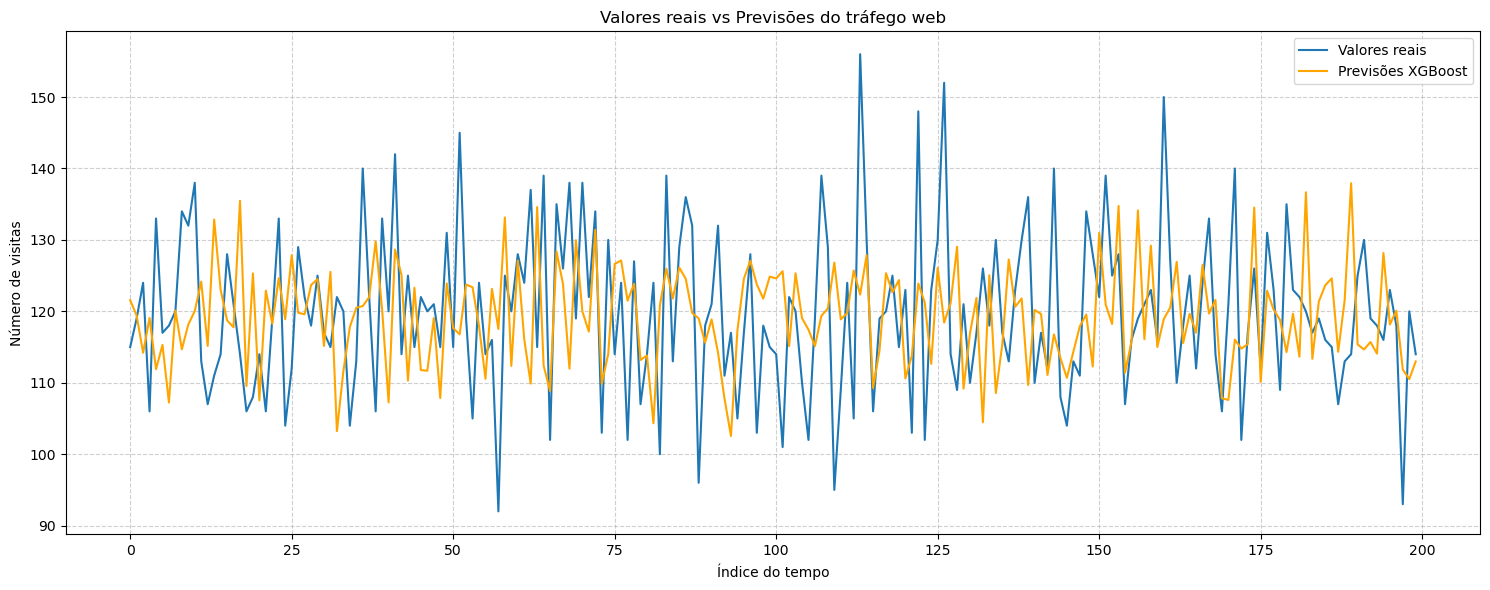

In [62]:
# Plot
plt.figure(figsize = (15, 6))
plt.plot(y_teste.values, label = 'Valores reais') 
plt.plot(previsoes, color = 'orange', label = 'Previsões XGBoost') 
plt.title('Valores reais vs Previsões do tráfego web')
plt.xlabel('Índice do tempo')
plt.ylabel('Número de visitas')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(loc = 'best') 
plt.show()

####  Scatter plot previsto vs real
Para ver a qualidade do ajuste (se previsões se alinham à reta y=x): Ideal para checar se o modelo sub ou superestima.

In [67]:
print(type(y_teste), y_teste.shape)
print(type(previsoes), previsoes.shape)

<class 'pandas.core.frame.DataFrame'> (200, 1)
<class 'numpy.ndarray'> (200,)


In [68]:
y_teste = y_teste.squeeze()  # transforma DataFrame (1 coluna) em Series

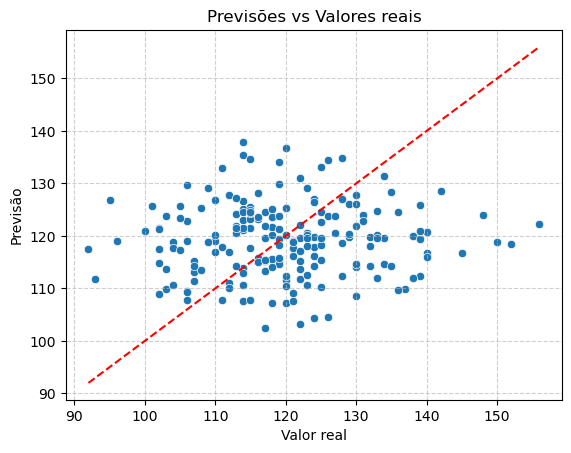

In [69]:
sns.scatterplot(x=y_teste, y=previsoes)
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], 'r--')
plt.title('Previsões vs Valores reais')
plt.xlabel('Valor real')
plt.ylabel('Previsão')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Erro residual
Plotar o erro (real - previsto) ao longo do tempo, para ver se há viés ou padrões: se houver padrão é ruim, o modelo não está bem ajustado, caso contrário o modelo aprendeu bem.

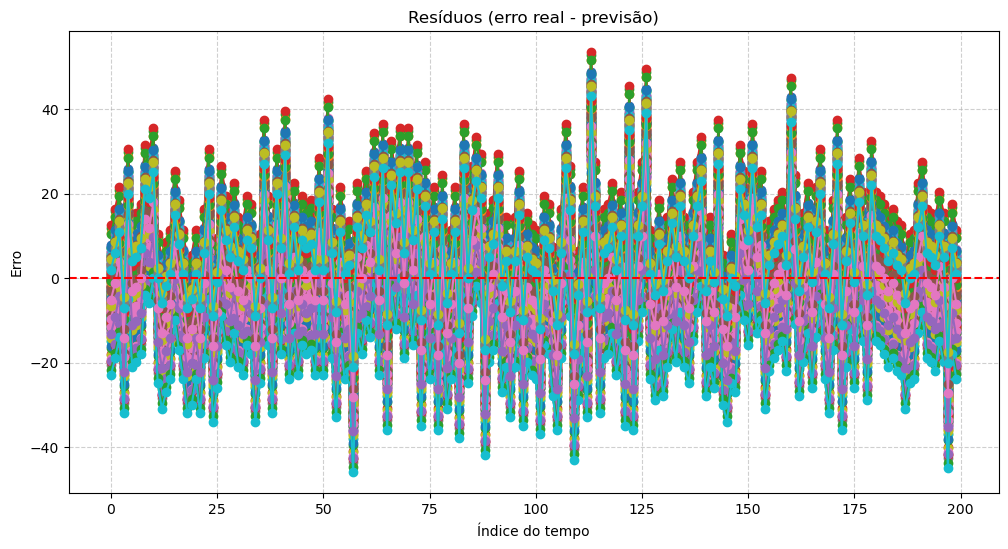

In [66]:
erros = y_teste.values - previsoes

plt.figure(figsize=(12,6))
plt.plot(erros, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos (erro real - previsão)')
plt.xlabel('Índice do tempo')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#### Avaliação do Modelo

In [15]:
# Avalia o modelo
mse = mean_squared_error(y_teste, previsoes)
rmse = np.sqrt(mse)

In [16]:
# Exibe o RMSE
print(f'RMSE do Modelo: {rmse}')

RMSE do Modelo: 12.941345233920575


**Análise das previsões do XGBoost | RMSE**

✅ Gráfico 1: valores reais vs previstos (linha)<br>
✅ Gráfico 2: previsão vs real (scatter, linha y=x)<br>
✅ Gráfico 3: resíduos ao longo do tempo<br>
✅ Gráfico 4: histograma + KDE dos resíduos

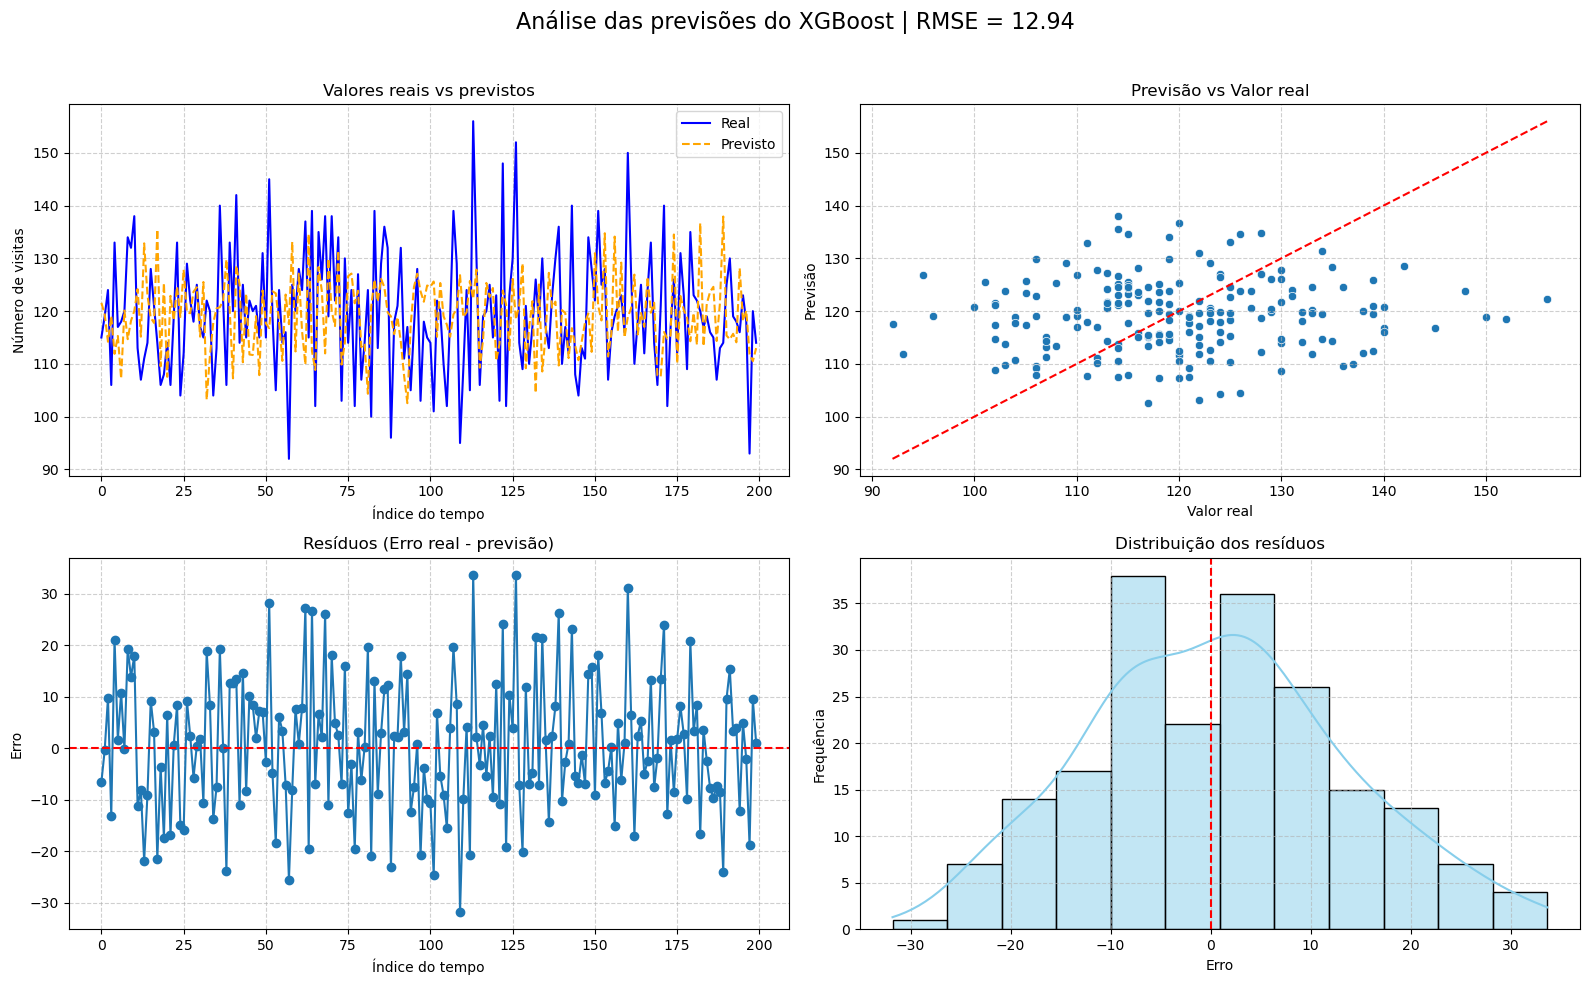

In [ ]:
# Plot RMSE Geral:

# garantir arrays corretos
y_real = np.array(y_teste).flatten()
y_pred = np.array(previsoes).flatten()
erros = y_real - y_pred

# calcular novamente para garantir
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)

# criar a figura
plt.figure(figsize=(16,10))
plt.suptitle(f'Análise das previsões do XGBoost | RMSE = {rmse:.2f}', fontsize=16)

# ------------------------------
# 1. Linha real vs previsto
plt.subplot(2,2,1)
plt.plot(y_real, label='Real', color='blue')
plt.plot(y_pred, label='Previsto', color='orange', linestyle='--')
plt.title('Valores reais vs previstos')
plt.xlabel('Índice do tempo')
plt.ylabel('Número de visitas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 2. Scatter previsão vs real
plt.subplot(2,2,2)
sns.scatterplot(x=y_real, y=y_pred)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.title('Previsão vs Valor real')
plt.xlabel('Valor real')
plt.ylabel('Previsão')
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 3. Resíduos no tempo
plt.subplot(2,2,3)
plt.plot(erros, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos (Erro real - previsão)')
plt.xlabel('Índice do tempo')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# 4. Distribuição dos resíduos
plt.subplot(2,2,4)
sns.histplot(erros, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribuição dos resíduos')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


📝 **Conclusão sobre o desempenho do modelo**

O modelo XGBoost desenvolvido para previsão do tráfego web apresentou um RMSE ≈ 12.94, indicando que, em média, suas previsões diferem dos valores reais em aproximadamente 13 visitas diárias. Dado que o volume típico de visitas gira em torno de 120 visitas por dia, o erro representa cerca de 10%, o que pode ser considerado um desempenho razoável para aplicações operacionais que tolerem pequenas flutuações.

A análise visual reforça esses achados:

* O gráfico temporal mostra que o modelo consegue acompanhar a tendência geral da série, embora apresente variações pontuais.

* O scatter plot evidencia que a maioria das previsões se aproxima da linha ideal (y=x), mas com certa dispersão, explicando o RMSE.

* O gráfico de resíduos ao longo do tempo indica que os erros não seguem um padrão claro, o que é positivo para descartar viés sistemático.

* Por fim, o histograma dos resíduos mostra uma distribuição aproximadamente centrada em zero, embora com caudas que justificam o nível do erro médio quadrático encontrado.

Dessa forma, o modelo é capaz de capturar o comportamento do tráfego com um nível de erro que pode ser considerado adequado para previsões de curto prazo, mas abre espaço para melhorias, como inclusão de novas variáveis explicativas ou testes com abordagens híbridas (ex.: XGBoost + variáveis sazonais ou lags adicionais).


#### Salva Modelo em formato Pkl

In [17]:
# Salva o modelo treinado em disco
joblib.dump(xgb_model, 'modelo_projeto_webtraffic.pkl')

['modelo_projeto_webtraffic.pkl']

#### Aplicação a novos Dados

In [18]:
import time  # Importar o módulo time para usar sleep
from realtime_data_generate import gera_dados_tempo_real

In [19]:
# Definir as features (incluindo a lag)
features = ['dia_semana', 'eh_feriado', 'campanha_marketing_ativa', 'taxa_media_conversao', 'num_visitas_dia_anterior', 'lag_num_visitas']

In [20]:
# Carregar o modelo salvo
xgb_model = joblib.load('modelo_projeto_webtraffic.pkl')

In [21]:
# Variável para armazenar a lag (tem que ser zero para a primeira previsão)
var_lag_num_visitas = 0  

In [22]:
# Função para gerar dados em tempo real e calcular a lag
def gerar_dados_realtime_com_lag(var_lag_num_visitas):
    
    # Gerar novos dados em tempo real
    real_time_data = gera_dados_tempo_real()

    # Adicionar a variável de lag (visitas do dia anterior)
    real_time_data['lag_num_visitas'] = var_lag_num_visitas

    return real_time_data

In [23]:
# Inicializar uma lista para armazenar as previsões
todas_previsoes = []

In [24]:
# Loop para gerar 7 previsões consecutivas
for i in range(7):

    # Gerar novos dados com lag
    real_time_data = gerar_dados_realtime_com_lag(var_lag_num_visitas)

    # Verificar se há dados para processar
    if not real_time_data.empty:
        
        # Preparar os dados para a previsão
        real_time_features = real_time_data[features]

        # Fazer a previsão
        predictions = xgb_model.predict(real_time_features)

        # Armazenar a previsão e as features utilizadas
        real_time_data['num_previsto_visitas'] = predictions.astype(int)
        todas_previsoes.append(real_time_data.copy())

        # Exibir os dados e a previsão atual
        print(f'\nPrevisão {i+1}:')
        print(f'Novos Dados de Entrada: {real_time_data[features].iloc[0].tolist()}')
        print(f'Previsão de Visitas: {real_time_data["num_previsto_visitas"].iloc[0]}\n')

        # Atualizar a lag para a próxima previsão
        var_lag_num_visitas = int(real_time_data['num_previsto_visitas'].iloc[0])

        # Pausar por 2 segundos antes da próxima previsão
        time.sleep(2)

# Após o loop, todas as previsões estão armazenadas na lista 'todas_previsoes'.


Previsão 1:
Novos Dados de Entrada: [1.0, 1.0, 0.0, 14.539469244616615, 99.0, 0.0]
Previsão de Visitas: 110


Previsão 2:
Novos Dados de Entrada: [4.0, 1.0, 1.0, 35.73476259499174, 104.0, 110.0]
Previsão de Visitas: 119


Previsão 3:
Novos Dados de Entrada: [5.0, 0.0, 0.0, 21.335737777334845, 115.0, 119.0]
Previsão de Visitas: 121


Previsão 4:
Novos Dados de Entrada: [3.0, 0.0, 0.0, 35.17697552499398, 99.0, 121.0]
Previsão de Visitas: 122


Previsão 5:
Novos Dados de Entrada: [1.0, 0.0, 0.0, 10.89201477468959, 101.0, 122.0]
Previsão de Visitas: 130


Previsão 6:
Novos Dados de Entrada: [0.0, 1.0, 1.0, 23.71038680367179, 109.0, 130.0]
Previsão de Visitas: 128


Previsão 7:
Novos Dados de Entrada: [2.0, 0.0, 0.0, 23.428166039009014, 112.0, 128.0]
Previsão de Visitas: 114



In [39]:
# ✅ Concatenar todas as previsões e salvar em CSV
df_previsoes = pd.concat(todas_previsoes, ignore_index=True)
df_previsoes.to_csv("previsoes.csv", index=False)

print("Arquivo previsoes.csv salvo com sucesso.")

Arquivo previsoes.csv salvo com sucesso.


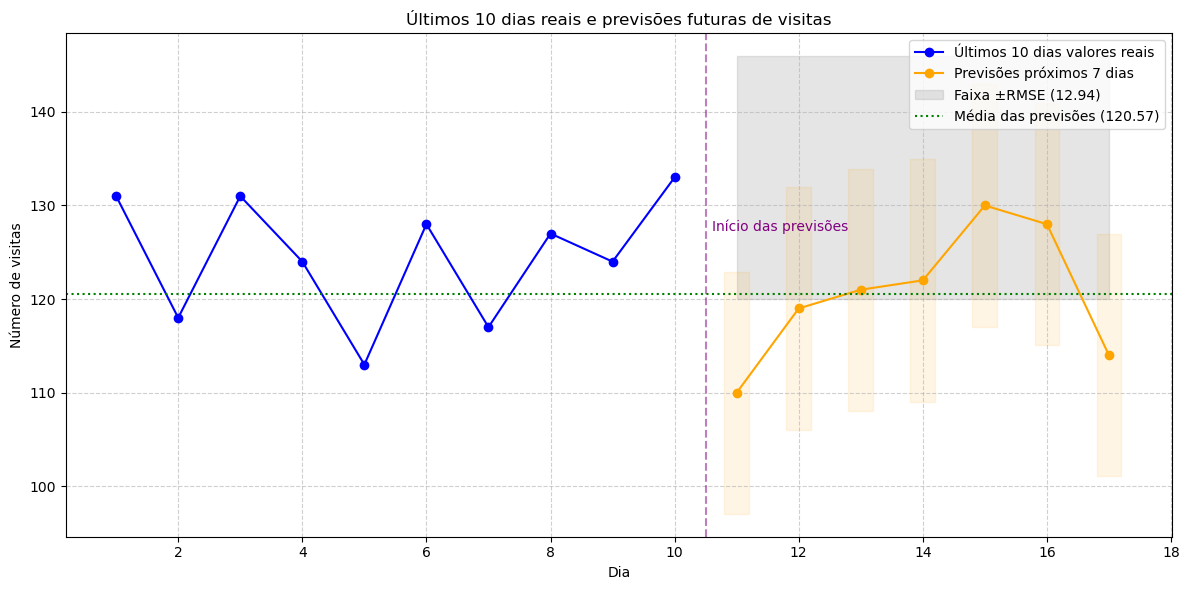

In [89]:
# extrair as previsões salvas no loop
prevs = [df['num_previsto_visitas'].iloc[0] for df in todas_previsoes]

# pegar os últimos 10 dias reais
valores_reais = df['lag_num_visitas'].tail(10).values
dias_reais = range(1, 11)

# último valor real (usado para faixa de confiança)
ultimo_real = valores_reais[-1]

# limites superior e inferior com base no RMSE
limite_sup = [ultimo_real + rmse] * 7
limite_inf = [ultimo_real - rmse] * 7

# dias de previsão após os reais
dias_previsao = range(11, 18)

plt.figure(figsize=(12, 6))

# plot últimos 10 valores reais
plt.plot(dias_reais, valores_reais, color='blue', linestyle='-', marker='o', label='Últimos 10 dias valores reais')

plt.axvline(x=10.5, color='purple', linestyle='--', alpha=0.5)
plt.text(10.6, plt.ylim()[1]*0.95, 'Início das previsões', color='purple')

# plot previsões
plt.plot(dias_previsao, prevs, marker='o', color='orange', label='Previsões próximos 7 dias')

# faixa de confiança ±RMSE
plt.fill_between(dias_previsao, limite_inf, limite_sup, color='gray', alpha=0.2,
                 label=f'Faixa ±RMSE ({rmse:.2f})')

# média das previsões
media_prevs = np.mean(prevs)
plt.axhline(media_prevs, color='green', linestyle=':', label=f'Média das previsões ({media_prevs:.2f})')

# faixa individual para cada previsão
for i, valor in enumerate(prevs):
    plt.fill_between(
        [dias_previsao[i] - 0.2, dias_previsao[i] + 0.2],
        [valor - rmse, valor - rmse],
        [valor + rmse, valor + rmse],
        color='orange',
        alpha=0.1
    )

plt.title('Últimos 10 dias reais e previsões futuras de visitas')
plt.xlabel('Dia')
plt.ylabel('Número de visitas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 📈 **Resumo do Gráfico de Visitas**

O gráfico mostra os **últimos 10 dias reais** em azul e as **previsões futuras** em laranja. 

A **faixa cinza (±RMSE)** indica o grau de incerteza nas estimativas. 

A **linha verde pontilhada** representa a média das previsões, oferecendo uma referência central.


- Se os pontos previstos estão **subindo**, há expectativa de aumento nas visitas.
- Se estão **descendo**, sinal de possível queda.
- A largura da faixa cinza mostra o nível de confiança: mais estreita = maior precisão.



In [87]:
plt.savefig("grafico_previsoes.png", dpi=300)

<Figure size 640x480 with 0 Axes>